=== ABLUP Study Setup ===
✓ Created 100 founders.
✓ Added trait and phenotyped founders.
✓ Evolving through 3 generations...
Creating generation 1...
  Generation 1 phenotyped.
Creating generation 2...
  Generation 2 phenotyped.
Creating generation 3...
  Generation 3 created as unphenotyped selection candidates.

✓ Multi-generational population created: 400 individuals across 4 generations.
  - Phenotyped (Training Set): 300 individuals
  - Unphenotyped (Prediction Set): 100 individuals

PERFORMING ABLUP PREDICTION
✓ ABLUP complete. Used h² = 0.8.

Prediction Accuracy for Final Generation: 0.1732


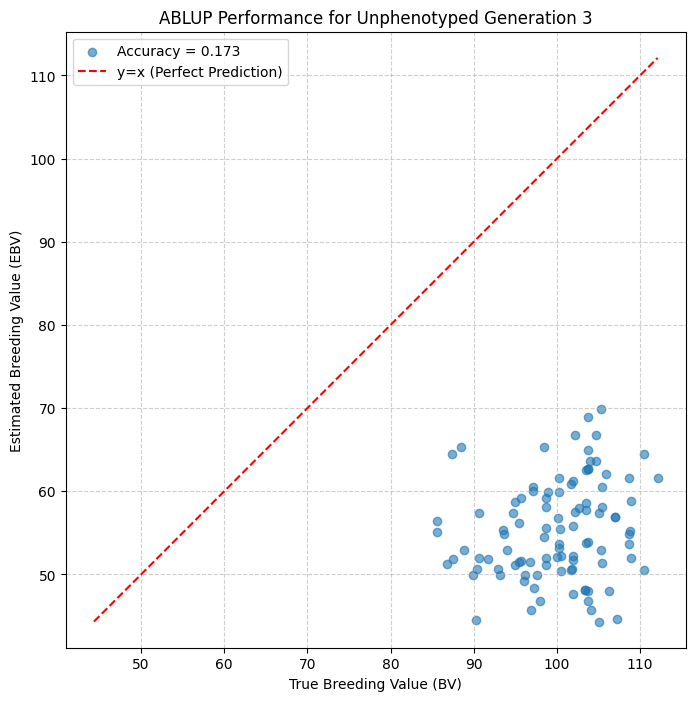

CPU times: user 2.38 s, sys: 46.5 ms, total: 2.42 s
Wall time: 700 ms


In [3]:
%%time

# ABLUP Study Setup - Population Evolution and Prediction
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import chewc components
from chewc.population import Population, quick_haplo, combine_populations, calc_a_matrix_pedigree
from chewc.sp import SimParam  
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.select import TruncationSelection
from chewc.cross import make_cross

# ### MODIFICATION START: Add prediction functions and PredictionResults class ###
# For a real project, these would be in a separate `predict.py` file.
from flax.struct import dataclass as flax_dataclass
from jax.numpy.linalg import inv
from typing import Optional, Dict
from flax.struct import dataclass

@dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

@jax.jit
def _solve_mixed_model_equations(X, Z, y, K_inv, alpha): # K can be G or A
    lhs_top = jnp.hstack([X.T @ X, X.T @ Z])
    lhs_bottom = jnp.hstack([Z.T @ X, Z.T @ Z + alpha * K_inv])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    rhs = jnp.concatenate([(X.T @ y).flatten(), (Z.T @ y).flatten()])
    solutions = jnp.linalg.solve(lhs, rhs)
    n_fixed = X.shape[1]
    return solutions[:n_fixed], solutions[n_fixed:], inv(lhs)

def ablup_predict(pop: Population, h2: float = 0.5, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1].at[jnp.isclose(pop.pheno[:, trait_idx], 0.0)].set(jnp.nan)
    train_mask = ~jnp.isnan(pheno.flatten())
    pred_mask = jnp.isnan(pheno.flatten())
    n_train, n_pred = jnp.sum(train_mask), jnp.sum(pred_mask)
    if n_train == 0: raise ValueError("No valid phenotypes for training.")
    
    A_full = calc_a_matrix_pedigree(pop)
    train_indices = jnp.where(train_mask)[0]
    A_train_train = A_full[jnp.ix_(train_indices, train_indices)]
    A_train_inv = inv(A_train_train)
    
    pheno_train = pheno[train_mask]
    X_train, Z_train = jnp.ones((n_train, 1)), jnp.identity(n_train)
    alpha = (1.0 - h2) / h2
    
    fixed_eff, ebv_train, C_inv = _solve_mixed_model_equations(X_train, Z_train, pheno_train, A_train_inv, alpha)
    
    all_ebv = jnp.full((pop.nInd, 1), jnp.nan)
    all_ebv = all_ebv.at[train_mask, 0].set(ebv_train)
    
    if n_pred > 0:
        pred_indices = jnp.where(pred_mask)[0]
        A_pred_train = A_full[jnp.ix_(pred_indices, train_indices)]
        ebv_pred = A_pred_train @ A_train_inv @ ebv_train
        all_ebv = all_ebv.at[pred_mask, 0].set(ebv_pred)
        
    var_p = jnp.var(pheno_train)
    var_a = var_p * h2
    n_fixed = X_train.shape[1]
    C22_inv = C_inv[n_fixed:, n_fixed:]
    pev_train = jnp.diag(C22_inv) * (var_p * (1 - h2))
    reliability_train = jnp.maximum(0, 1 - (pev_train / var_a))
    all_reliability = jnp.full((pop.nInd,), jnp.nan)
    all_reliability = all_reliability.at[train_mask].set(reliability_train)
    
    return PredictionResults(ids=pop.id, ebv=all_ebv, reliability=all_reliability, fixed_effects=fixed_eff, h2_used=h2)
# ### MODIFICATION END ###


print("=== ABLUP Study Setup ===")
key = jax.random.PRNGKey(42)

# ====================================================================
# 1. CREATE FOUNDER POPULATION AND SETUP
# ====================================================================
key, founder_key = jax.random.split(key)
founder_pop, gen_map = quick_haplo(key=founder_key, n_ind=100, n_chr=1, n_loci_per_chr=1000, ploidy=2)
sp = SimParam.from_founder_pop(founder_pop, gen_map)
print(f"✓ Created {founder_pop.nInd} founders.")

# ====================================================================
# 2. ADD TRAIT AND SET PHENOTYPES FOR FOUNDERS
# ====================================================================
key, trait_key, pheno_key = jax.random.split(key, 3)
sp = add_trait_a(key=trait_key, founder_pop=founder_pop, sim_param=sp, n_qtl_per_chr=20, mean=jnp.array([100.0]), var=jnp.array([400.0]))
founder_pop = set_bv(founder_pop, sp.traits, sp.ploidy)
founder_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits, ploidy=sp.ploidy, h2=jnp.array([0.3]))
print(f"✓ Added trait and phenotyped founders.")

# ====================================================================
# 3. EVOLUTION THROUGH 3 GENERATIONS (PHENOTYPED) + 1 GENERATION (UNPHENOTYPED)
# ====================================================================
selector = TruncationSelection()
n_parents = int(founder_pop.nInd * 0.2)
all_populations = [founder_pop]
current_pop = founder_pop
current_id = founder_pop.nInd

# ### MODIFICATION: Evolve for 4 generations total ###
N_GEN = 3
print(f"✓ Evolving through {N_GEN} generations...")

for gen in range(1, N_GEN + 1):
    print(f"Creating generation {gen}...")
    key, select_key, mating_key, father_key, cross_key, pheno_key = jax.random.split(key, 6)
    
    parent_indices = selector.select_parents(key=select_key, pop=current_pop, sp=sp, n_select=n_parents)
    
    n_crosses = current_pop.nInd
    mother_indices = jax.random.choice(mating_key, len(parent_indices), shape=(n_crosses,), replace=True)
    father_indices = jax.random.choice(father_key, len(parent_indices), shape=(n_crosses,), replace=True)
    cross_plan = jnp.column_stack([parent_indices[mother_indices], parent_indices[father_indices]])
    
    offspring_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp, next_id_start=current_id)
    
    # Set breeding values for all offspring
    offspring_pop = set_bv(offspring_pop, sp.traits, sp.ploidy)
    
    # ### MODIFICATION: Only phenotype generations 1, 2, and 3. Leave Gen 4 unphenotyped. ###
    if gen < N_GEN:
        offspring_pop = set_pheno(key=pheno_key, pop=offspring_pop, traits=sp.traits, ploidy=sp.ploidy, h2=jnp.array([0.3]))
        print(f"  Generation {gen} phenotyped.")
    else:
        # For the final generation, we set phenotypes to NaN to mark them for prediction
        nan_phenos = jnp.full_like(offspring_pop.pheno, jnp.nan)
        offspring_pop = offspring_pop.replace(pheno=nan_phenos)
        print(f"  Generation {gen} created as unphenotyped selection candidates.")

    all_populations.append(offspring_pop)
    current_id += offspring_pop.nInd
    current_pop = offspring_pop

# ====================================================================
# 4. CREATE MULTI-GENERATIONAL POPULATION FOR PEDIGREE
# ====================================================================
multi_gen_pop = all_populations[0]
for pop in all_populations[1:]:
    multi_gen_pop = combine_populations(multi_gen_pop, pop)

print(f"\n✓ Multi-generational population created: {multi_gen_pop.nInd} individuals across {len(all_populations)} generations.")
n_phenotyped = jnp.sum(~jnp.isnan(multi_gen_pop.pheno))
n_unphenotyped = jnp.sum(jnp.isnan(multi_gen_pop.pheno))
print(f"  - Phenotyped (Training Set): {n_phenotyped} individuals")
print(f"  - Unphenotyped (Prediction Set): {n_unphenotyped} individuals")

# ====================================================================
# 5. PERFORM ABLUP PREDICTION
# ====================================================================
print("\n" + "="*50)
print("PERFORMING ABLUP PREDICTION")
print("="*50)

# Use the multi-generational population to get the full pedigree context
h2_assumed = 0.8
prediction_results = ablup_predict(multi_gen_pop, h2=h2_assumed)

print(f"✓ ABLUP complete. Used h² = {h2_assumed}.")

# ====================================================================
# 6. VALIDATE AND VISUALIZE RESULTS
# ====================================================================
# Extract results for the final, unphenotyped generation
final_pop = all_populations[-1]
final_gen_start_id = final_pop.id[0]
final_gen_mask = multi_gen_pop.id >= final_gen_start_id

true_bvs_final_gen = multi_gen_pop.bv[final_gen_mask, 0]
ebvs_final_gen = prediction_results.ebv[final_gen_mask, 0]

# Calculate prediction accuracy (correlation between true and estimated BVs)
accuracy = jnp.corrcoef(true_bvs_final_gen, ebvs_final_gen)[0, 1]
print(f"\nPrediction Accuracy for Final Generation: {accuracy:.4f}")

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(true_bvs_final_gen, ebvs_final_gen, alpha=0.6, label=f'Accuracy = {accuracy:.3f}')
# Add a y=x line for reference
min_val = min(jnp.min(true_bvs_final_gen), jnp.min(ebvs_final_gen))
max_val = max(jnp.max(true_bvs_final_gen), jnp.max(ebvs_final_gen))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Prediction)')
plt.xlabel("True Breeding Value (BV)")
plt.ylabel("Estimated Breeding Value (EBV)")
plt.title(f"ABLUP Performance for Unphenotyped Generation {N_GEN}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show()